In [8]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import ShiryaevStrategy
from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

# Running the strategy
## Shiryaev


In [9]:
df_ptf = generate_n_assets_portfolio(
    1,
    n_steps=250,
    T=1,
    H=0.7,
    mu=0.05,
    sigma=0.1,
    s0=100,
    add_risk_free_asset=True,
    as_dataframe=True,
    brownian_type="fractional",
)
df_ptf

,S_0_t,S_1_t
0.000000,100.0,100.000000
0.004016,100.0,99.859203
0.008032,100.0,99.648273
0.012048,100.0,99.564516
0.016064,100.0,99.577534
...,...,...
0.983936,100.0,120.994980
0.987952,100.0,121.198448
0.991968,100.0,120.915835
0.995984,100.0,120.890964


In [10]:


# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma

shiryaev_strat = ShiryaevStrategy(
    risk_free_asset_name="S_0_t", scaling_factor=SCALING_FACTOR
)

bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_ptf,
    allocation_function=shiryaev_strat.get_allocation,
    p1=P1,
    p2=P2,
)

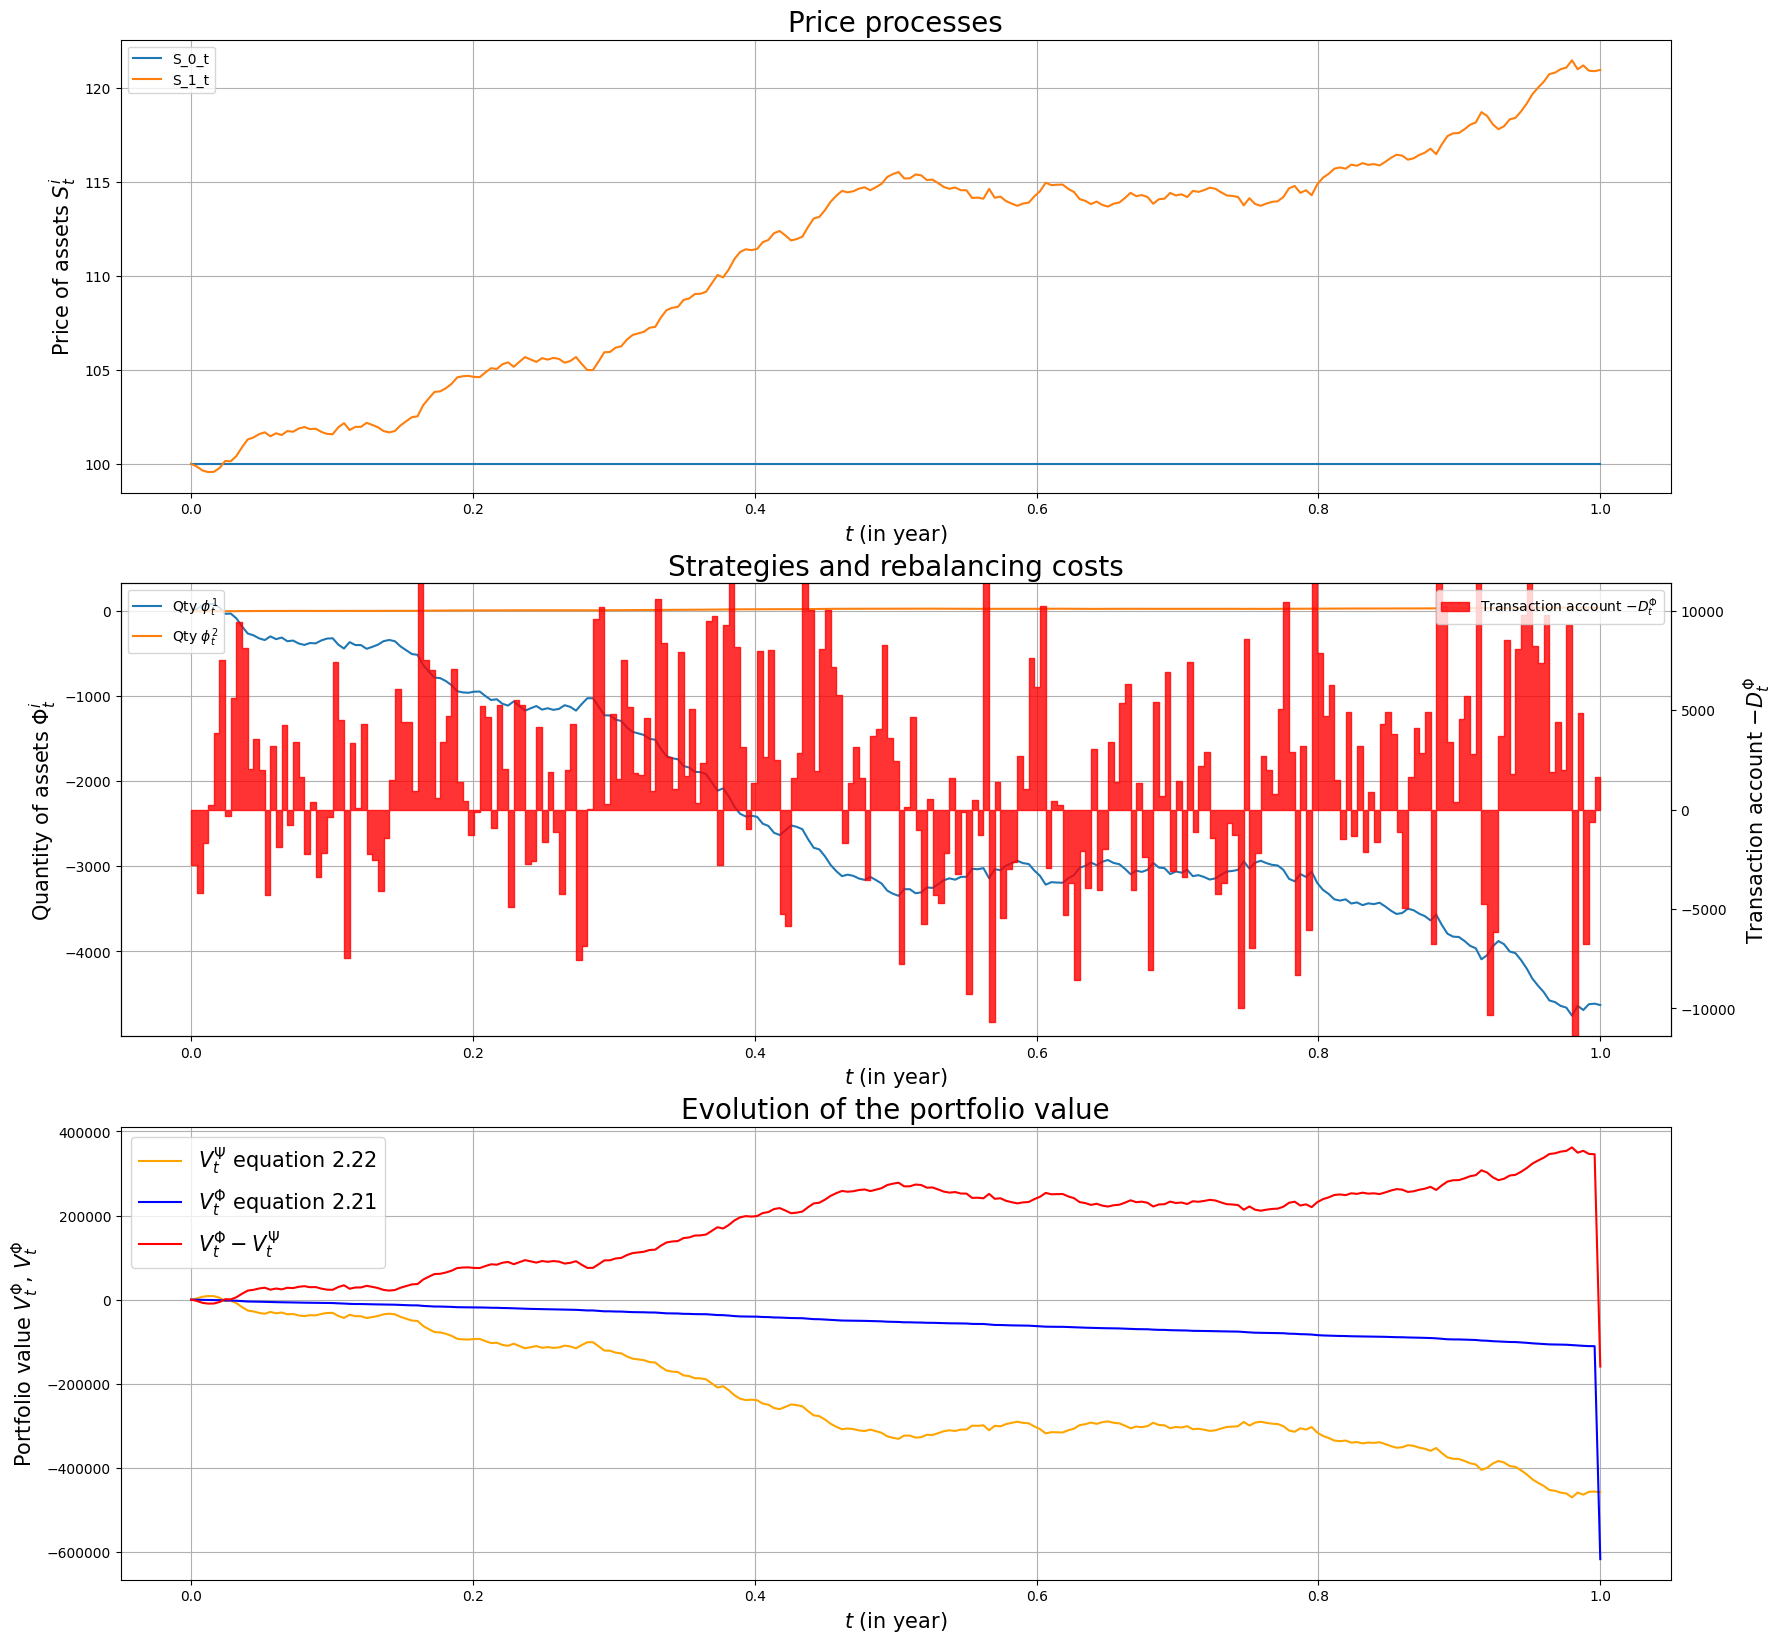

In [11]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -transaction_account,
    color="red",
    step="pre",
    alpha=0.8,
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_ptf.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

# Monte carlo simulation


In [12]:
N_SIMULATION = 10

ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = ShiryaevStrategy(risk_free_asset_name="S_0_t",scaling_factor=SCALING_FACTOR)
bk_tester = Backtester()

all_V_t_psi = []
all_V_t_phi = []
all_transaction_account = []

for _ in tqdm(
    range(N_SIMULATION),
    leave=False,
    desc="Computing MC simulation...",
    total=N_SIMULATION,
):
    df_ptf = generate_n_assets_portfolio(
        n_assets=2,
        n_steps=250,
        T=1,
        H=0.7,
        mu=0.05,
        sigma=0.1,
        s0=100,
        add_risk_free_asset=False,
        as_dataframe=True,
        brownian_type="fractional",
    )
    _, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
        universe_dataframe=df_ptf,
        allocation_function=salopek_strat.get_allocation,
        p1=P1,
        p2=P2,
    )
    all_V_t_psi.append(V_t_psi)
    all_V_t_phi.append(V_t_phi)
    all_transaction_account.append(transaction_account)
    del df_ptf

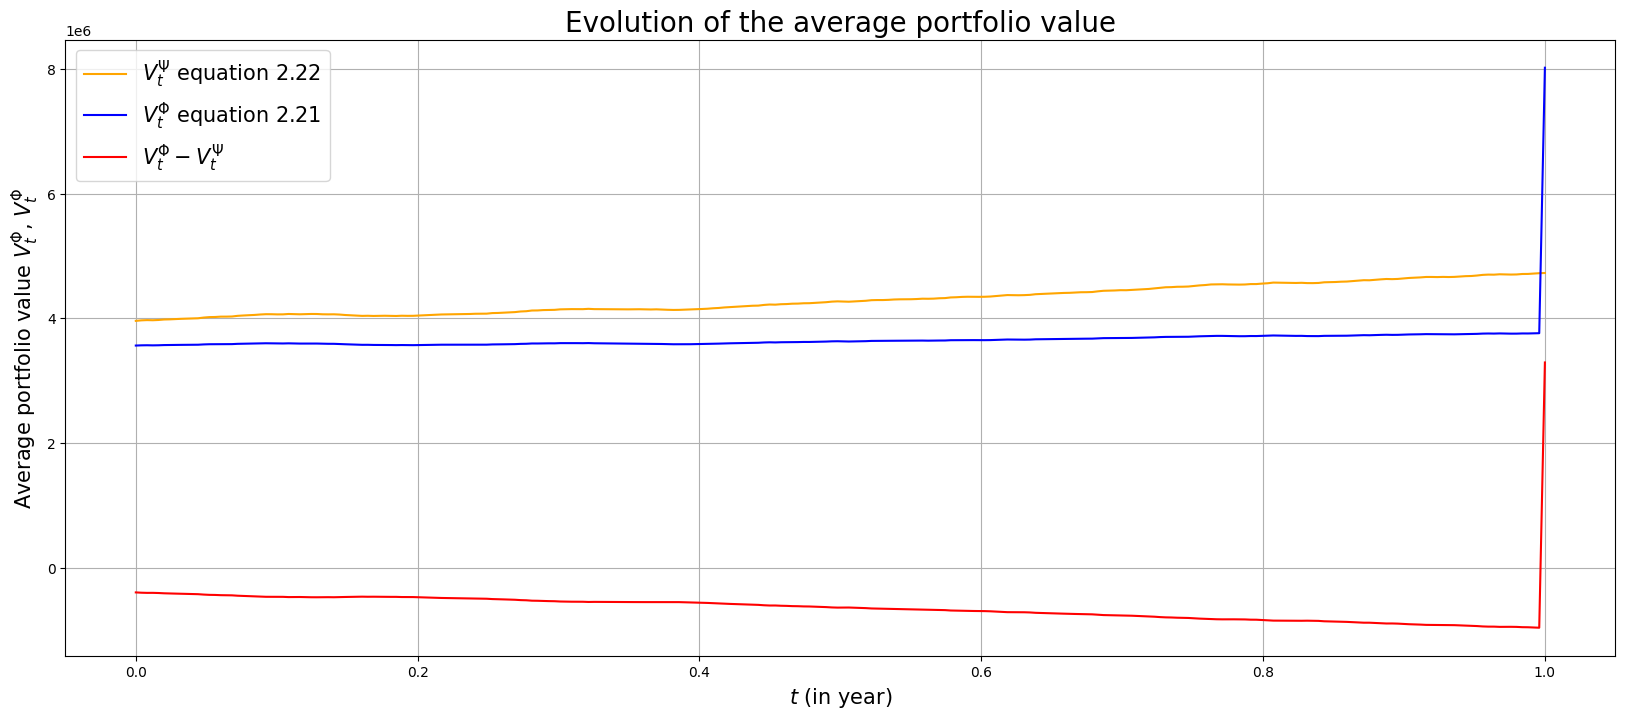

In [13]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
t = generate_t(250, 1)
ax.plot(
    t, np.mean(all_V_t_psi, axis=0), label=r"$V_t^\Psi$ equation 2.22", color="orange"
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0),
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0) - np.mean(all_V_t_psi, axis=0),
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel(r"Average portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax.set_title(f"Evolution of the average portfolio value", fontsize=20)
ax.grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax.legend(fontsize=15, loc="upper left")

# Real data


In [ ]:
df_ptf = pd.read_csv("../data/data_engie_axa.csv", sep=",").ffill()
df_ptf["Date"] = pd.to_datetime(df_ptf["Date"])
df_ptf = df_ptf.set_index("Date").sort_index().loc["2020-03-01":]
# df_ptf = (df_ptf.pct_change().fillna(99) + 1).cumprod().loc["2020-01-01":]

plt.figure(figsize=(20, 8))
plt.plot(df_ptf["ENGI FP Equity"], label="ENGI FP Equity", color="blue")
plt.plot(df_ptf["CS FP Equity"], label="CS FP Equity", color="orange")
plt.xlabel("Datetime")
plt.ylabel("Normalized price")
plt.title("ENGI FP Equity vs CS FP Equity")
plt.grid()
plt.legend()

df_ptf

In [ ]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = ShiryaevStrategy(alpha=ALPHA, beta=BETA)


bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_ptf,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
    scaling_factor=SCALING_FACTOR,
)

In [ ]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_ptf.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

# Idées

- Vol sto
- Données réelles avec exposant de Hurst cross section
  $$\hat{H}=-\frac{1}{2log(2)}log(\frac{1}{2}\frac{\sum_{i=0}^{N-1}(B_H((i+1)/N)-B_H(i/N))^2}{\sum_{i=0}^{(N/2)-1}(B_H(2(i+1)/N)-B_H(2i/N))^2})$$
- Prouver arbitrage pourquoi H>0.5 fonctionne et pas H=0.5 (dominance sto ?)
-
